In [ ]:
from google.colab import drive
import os

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_dir = '/content/drive/MyDrive/Dataset proyek skripsi/Dataset/train'
test_dir = '/content/drive/MyDrive/Dataset proyek skripsi/Dataset/test'

In [ ]:

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import os


In [ ]:
# Parameter preprocessing
img_height = 224
img_width = 224
batch_size = 22
num_classes = 4

In [ ]:
# ImageDataGenerator untuk train dan validasi
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    zoom_range=0.1,
    shear_range=0.5,
    width_shift_range=0.02,
    height_shift_range=0.02,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

In [ ]:
#Data Train
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

Found 1055 images belonging to 4 classes.


In [ ]:
#Data Validation
val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 261 images belonging to 4 classes.


In [ ]:
#Data Test
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 228 images belonging to 4 classes.


In [ ]:
# Ambil 1 batch (32 gambar pertama) dari train_generator
images, labels = next(train_generator)

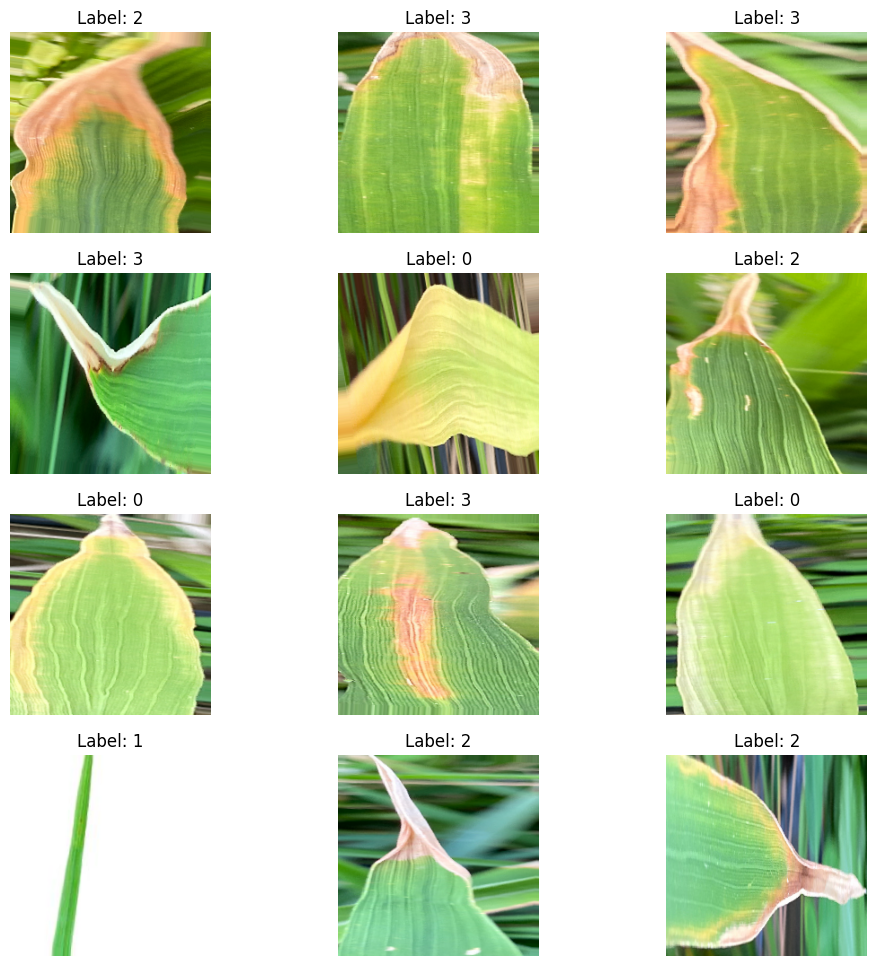

In [ ]:
plt.figure(figsize=(12, 12))
for i in range(12):  # tampilkan 9 gambar pertama
    plt.subplot(4, 3, i+1)
    plt.imshow(images[i])
    plt.title(f"Label: {np.argmax(labels[i])}")
    plt.axis('off')
plt.show()

In [ ]:
# Load MobileNetV3Small tanpa top layer
base_model = MobileNetV3Small(
    input_shape=(img_height, img_width, 3),
    include_top=False,
    weights='imagenet'
)

4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Freeze base model
base_model.trainable = False

In [ ]:
# Bangun model akhir
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.005)),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(num_classes, activation='softmax')
])

In [ ]:
# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ MobileNetV3Small (Functional)   │ (None, 7, 7, 576)      │       939,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 576)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,021,492 (3.90 MB)

 Trainable params: 82,372 (321.77 KB)

 Non-trainable params: 939,120 (3.58 MB)

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    callbacks=[early_stop, reduce_lr]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 227s 5s/step - accuracy: 0.2400 - loss: 2.4472 - val_accuracy: 0.2481 - val_loss: 2.3222 - learning_rate: 1.0000e-04
Epoch 2/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.2458 - loss: 2.3290 - val_accuracy: 0.2519 - val_loss: 2.2243 - learning_rate: 1.0000e-04
Epoch 3/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.2401 - loss: 2.2332 - val_accuracy: 0.2519 - val_loss: 2.1397 - learning_rate: 1.0000e-04
Epoch 4/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.2399 - loss: 2.1448 - val_accuracy: 0.2595 - val_loss: 2.0654 - learning_rate: 1.0000e-04
Epoch 5/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.2444 - loss: 2.0642 - val_accuracy: 0.2519 - val_loss: 2.0001 - learning_rate: 1.0000e-04
Epoch 6/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.2768 - loss: 1.9915 - val_accuracy: 0.2366 - val_loss: 1.9429 - learning_rate: 1.0000e-04
Epoch 7/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.2730

In [ ]:
# Simpan model
model.save('/content/drive/MyDrive/Dataset proyek skripsi/best_model_before_finetune(normbg).keras')

In [ ]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test accuracy: {test_accuracy:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


11/11 ━━━━━━━━━━━━━━━━━━━━ 105s 10s/step - accuracy: 0.5399 - loss: 1.3432
Test accuracy: 0.5263


NameError: name 'history' is not defined

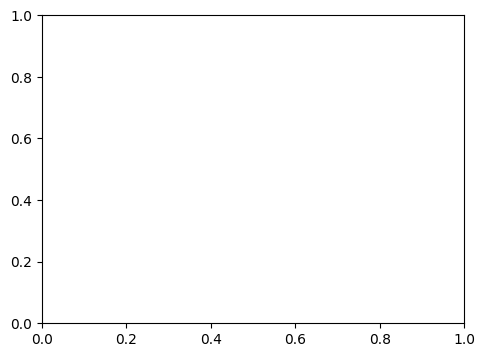

In [ ]:
  # Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.legend()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Prediksi
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Ambil label asli
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Cetak Confusion Matrix
print("Confusion Matrix")
print(confusion_matrix(y_true, y_pred, labels=[0, 1, 2, 3]))

# Cetak Classification Report
print("Classification Report")
print(classification_report(y_true, y_pred, target_names=class_labels, labels=[0, 1, 2, 3]))

11/11 ━━━━━━━━━━━━━━━━━━━━ 15s 917ms/step
Confusion Matrix
[[57  0  0  0]
 [57  0  0  0]
 [57  0  0  0]
 [57  0  0  0]]
Classification Report
               precision    recall  f1-score   support

  Nitrogen(N)       0.25      1.00      0.40        57
       Normal       0.00      0.00      0.00        57
Phosphorus(P)       0.00      0.00      0.00        57
 Potassium(K)       0.00      0.00      0.00        57

     accuracy                           0.25       228
    macro avg       0.06      0.25      0.10       228
 weighted avg       0.06      0.25      0.10       228



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


NameError: name 'history' is not defined

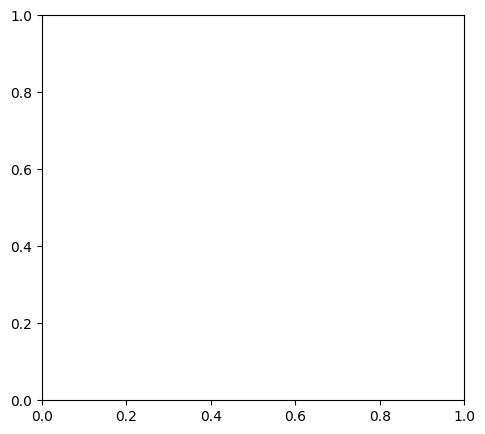

In [ ]:
# Plot akurasi
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Grafik Akurasi')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Grafik Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

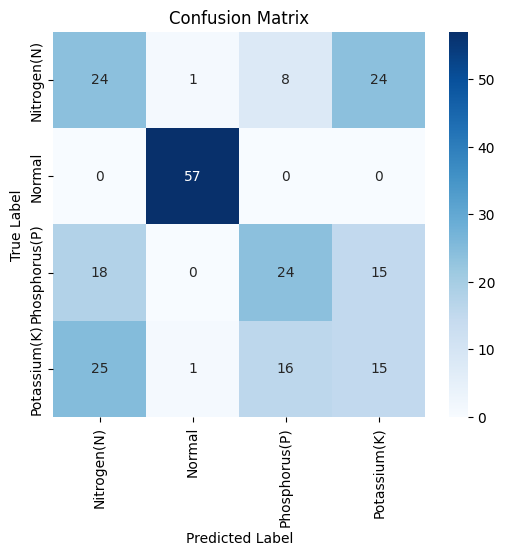

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
import time
from tensorflow.keras.preprocessing import image

# Ambil satu sampel gambar dari test set
sample_image_path = test_generator.filepaths[0]
img = image.load_img(sample_image_path, target_size=(img_height, img_width))
input_arr = image.img_to_array(img) / 255.0
input_arr = np.expand_dims(input_arr, axis=0)

# Mulai waktu
start_time = time.time()

# Lakukan prediksi
model.predict(input_arr)

# Selesai
end_time = time.time()

# Hitung waktu
inference_time = end_time - start_time
print(f"⏱️ Waktu inferensi 1 gambar: {inference_time:.4f} detik")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
⏱️ Waktu inferensi 1 gambar: 1.4026 detik


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Prediksi pada test set
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Label asli
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Classification report
report = classification_report(y_true, y_pred, target_names=class_labels, digits=4)
print("=== Classification Report ===")
print(report)

11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 610ms/step
=== Classification Report ===
               precision    recall  f1-score   support

  Nitrogen(N)     0.3582    0.4211    0.3871        57
       Normal     0.9661    1.0000    0.9828        57
Phosphorus(P)     0.5000    0.4211    0.4571        57
 Potassium(K)     0.2778    0.2632    0.2703        57

     accuracy                         0.5263       228
    macro avg     0.5255    0.5263    0.5243       228
 weighted avg     0.5255    0.5263    0.5243       228



In [ ]:
# 2. Simpan model
model.save('/content/drive/MyDrive/Dataset proyek skripsi/model1.h5')

In [ ]:
model = tf.keras.models.load_model("model1.keras", compile=False)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("model1.tflite", "wb") as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmpeguclcoa'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  132943600291280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132943600295696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132943600296080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132943600295888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132943600293968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132943600297232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132943600297616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132943600298000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132943600297808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132943600295120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1329436002991